In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.proportion import proportions_ztest

# 1. Data Visualization

Here is the link of our dashboard:

https://public.tableau.com/app/profile/shangxuan.zhong/viz/AD654-Project_17454516184220/dashboard

And also, here is a picture of the whole dashboard.

![dashboard](image/dashboard.png)

To support Lobster Land's exploration into the cruise industry, I've built a dashboard that highlights key trends and operational characteristics across cruise lines. The goal is to provide a clear picture of the landscape, especially as you weigh options like co-sponsoring a cruise, chartering, or eventually operating your own ship out of Portland.

One of the main takeaways is the strong link between ship tonnage and passenger capacity, as shown in the Passenger Capacity vs. Tonnage scatter plot. Bigger ships, like those operated by Royal Caribbean and Carnival, can carry more passengers, while luxury lines such as Silversea and Regent Seven Seas intentionally keep their ships smaller for a more exclusive experience. The Average Passenger Density bar chart is especially useful for understanding how much space passengers get. Luxury lines average 50 to 60 tons of ship per passenger, creating a spacious and upscale environment. On the other hand, mass-market lines like Carnival and Royal Caribbean average closer to 36, which supports higher passenger volumes but a less premium feel. When it comes to service, the Crew-to-Passenger Ratio treemap reveals important differences. Norwegian Cruise Line stands out here, with about 5.8 crew members per 100 passengers, pointing to a stronger service orientation compared to others in its class. The Cabins vs. Passengers scatter plot confirms what we'd expect: more passengers generally mean more cabins. But some ships, like Royal Caribbean's Oasis, push passenger numbers higher relative to cabin count, probably by offering more shared or multi-person accommodations.

Consequently, for a Maine-based brand with a strong identity and family appeal, I'd recommend exploring vessels similar in size to those used by Oceania, Azamara, or Windstar. These small to mid-sized ships are a good fit for Portland's port infrastructure and offer a higher-end experience without entering the ultra-luxury space. Based on the data, vessels in the 3000 to 7000 ton range that carry 200 to 800 passengers seem ideal. Maintaining a passenger density around 40 to 45 tons per guest, comparable to lines like Holland America, would strike a nice balance between comfort and capacity. Lastly, leveraging Lobster Land's unique branding and Maine heritage could be a real asset. Whether through co-sponsoring themed sailings or testing the waters with a seasonal charter, there's a clear opportunity to carve out a niche that's different from the big players. Starting small lets you gauge interest while building brand equity in the cruise space, without the upfront risk of buying a ship right away.

# 2. Summary Stats 

In [3]:
df = pd.read_csv("data/caribbean_ports.csv")
df.head()

,port_id,port_name,country_or_territory,region,port_type,latitude,longitude,avg_annual_visitors,avg_port_fee_usd,local_attractions_score,avg_customer_satisfaction,excursion_variety_index,avg_disembark_rate,avg_shore_spend_per_passenger,seasonality_score
0,1,Cozumel,Mexico,Western,Private,23.7406,-66.7748,187848,13.75,6,8.23,2,0.82,175.22,0.99
1,2,Costa Maya,Mexico,Western,Eco/Nature,13.4943,-65.7182,667075,13.77,3,9.74,10,0.52,100.07,0.78
2,3,Progreso,Mexico,Western,Major,18.9991,-83.1489,177948,12.11,9,8.78,3,0.69,156.40,0.44
3,4,Belize City,Belize,Western,Private,20.3673,-76.0384,452690,4.53,4,12.50,1,0.81,157.05,0.18
4,5,Roatán,Honduras,Western,Private,10.8129,-82.1033,549046,17.20,1,6.39,8,0.75,43.05,0.80


In [4]:
df.describe()
summary_stats = df.describe()
summary_stats.head()

,port_id,latitude,longitude,avg_annual_visitors,avg_port_fee_usd,local_attractions_score,avg_customer_satisfaction,excursion_variety_index,avg_disembark_rate,avg_shore_spend_per_passenger,seasonality_score
count,50.00000,50.000000,50.000000,50.000000,50.000000,50.000000,50.00000,50.000000,50.000000,50.000000,50.000000
mean,25.50000,18.470906,-72.804902,706128.640000,10.706200,4.440000,8.19820,5.980000,0.764000,112.894200,0.566200
std,14.57738,5.560868,7.250157,451773.228146,5.430777,2.865417,1.27086,3.040475,0.165603,58.994124,0.284461
min,1.00000,10.096600,-84.364500,71959.000000,-3.500000,1.000000,6.12000,1.000000,0.510000,-45.000000,0.110000
25%,13.25000,13.441650,-79.151925,276104.750000,5.802500,2.250000,7.37250,4.000000,0.640000,56.592500,0.350000


In [5]:
#  Average annual visitors by country
avg_visitors_by_country = df.groupby("country_or_territory")["avg_annual_visitors"].mean().sort_values(ascending=False)
top_visitors_by_country = avg_visitors_by_country.head(5)
print(top_visitors_by_country)

country_or_territory
Sint Maarten           1.413453e+06
Venezuela              1.282310e+06
Trinidad and Tobago    1.191840e+06
Dominican Republic     1.170601e+06
Curaçao                8.631680e+05
Name: avg_annual_visitors, dtype: float64


In [6]:
#top regions by number of ports
port_count_by_region = df["region"].value_counts()
top_regions_by_port_count = port_count_by_region.head(5)
print(top_regions_by_port_count)

region
Eastern     16
Western     15
Southern    11
Bahamas      8
Name: count, dtype: int64


In [7]:
#pivot table
pivot_table = pd.pivot_table(
    df,
    values="avg_shore_spend_per_passenger",
    index="region",
    columns="port_type",
    aggfunc="mean"
)

print(pivot_table)

port_type    Boutique  Eco/Nature    Major   Private
region                                              
Bahamas    186.245000         NaN  169.630   57.4660
Eastern    128.746667     118.345  119.224   96.6700
Southern   116.062500     103.258      NaN  103.2800
Western     47.755000     130.622  117.695  130.7475


In [8]:
mean_satisfaction = df.groupby("region")["avg_customer_satisfaction"].mean().sort_values(ascending=False)
top_satisfaction = mean_satisfaction.head(5)
print(top_satisfaction)

region
Bahamas     8.380000
Eastern     8.316875
Western     8.156000
Southern    7.950909
Name: avg_customer_satisfaction, dtype: float64


Sint Maarten and Venezuela attract the highest number of visitors annually, making them ideal targets for focused marketing campaigns to boost brand visibility and tourist engagement. The Eastern and Western Caribbean regions, with the most ports, offer strategic hubs for regional promotions and cruise partnerships. The high passenger spending at Boutique ports in the Bahamas suggests a great opportunity for marketing premium experiences and upscale excursions. Additionally, with customer satisfaction highest in the Bahamas and Eastern region, marketing efforts can highlight these areas as top-rated destinations, using positive reviews to attract more travelers.

# 3. Segmentation and Targeting

# 4. Conjoint Analysis & Recommendation

In [10]:
# Load the data
voyage_options = pd.read_csv('data/voyage_options.csv')
vendor_costs = pd.read_csv('data/vendor_costs_654.csv')

# Display basic info about the data
print("Voyage Options Data:")
print(voyage_options.head())
print("\nVendor Costs Data:")
print(vendor_costs.head())

Voyage Options Data:
     entertainment                                    dining  \
0  East Coast Folk  Maine Lobster Nova Scotia Seafood Buffet   
1  East Coast Folk  Maine Lobster Nova Scotia Seafood Buffet   
2  East Coast Folk  Maine Lobster Nova Scotia Seafood Buffet   
3  East Coast Folk  Maine Lobster Nova Scotia Seafood Buffet   
4  East Coast Folk  Maine Lobster Nova Scotia Seafood Buffet   

                 cabin            amenities  cocktail_credits  avg_rating  
0  Cozy with Fireplace    Top Deck Hot Tubs                 1    8.313079  
1  Cozy with Fireplace    Top Deck Hot Tubs                 2    9.435885  
2  Cozy with Fireplace    Top Deck Hot Tubs                 3    8.540985  
3  Cozy with Fireplace  Winter Wellness Spa                 1    8.415454  
4  Cozy with Fireplace  Winter Wellness Spa                 2    9.241294  

Vendor Costs Data:
                                       Item  Item Category  \
0                           East Coast Folk  entertainme

In [12]:
# Prepare data for conjoint analysis
features = ['entertainment', 'dining', 'cabin', 'amenities', 'cocktail_credits']
X = pd.get_dummies(voyage_options[features], drop_first=False)

# Convert to numpy arrays to avoid dtype issues
X = X.astype(float)  
y = voyage_options['avg_rating'].values  

# Add constant term
X = sm.add_constant(X)

# Fit linear regression model for conjoint analysis
model = sm.OLS(y, X).fit()

# Get part-worth utilities (coefficients)
part_worth = model.params[1:]  # Exclude the constant term
print("\nPart-worth utilities (coefficients):")
print(part_worth)

# Calculate importance of each attribute
importance = {}
for feature in features:
    col_mask = part_worth.index.str.startswith(feature)
    importance[feature] = (part_worth[col_mask].max() - part_worth[col_mask].min()) / part_worth.abs().sum() * 100

print("\nAttribute Importance (%):")
print(importance)


Part-worth utilities (coefficients):
cocktail_credits                                  -0.266540
entertainment_Acoustic Showcase                    0.838775
entertainment_DJ_Dance                             0.140997
entertainment_East Coast Folk                      1.283075
entertainment_Jazz Blues                           1.194150
dining_Casual Fireside Grill with Hot Cider        0.608897
dining_Coastal Tapas & Tasting Stations            0.901833
dining_Formal Multi-Course Plated                 -0.159852
dining_Maine Lobster Nova Scotia Seafood Buffet    2.106119
cabin_Cozy with Fireplace                          0.890427
cabin_Modern Minimalist                            0.440748
cabin_Nautical Chic                                1.202862
cabin_Romantic Escape                              0.922960
amenities_Fireside Live Music                      0.825440
amenities_Top Deck Hot Tubs                        1.728434
amenities_Winter Wellness Spa                      0.903123
dt

In [13]:
# Find the best combination within budget
# First create a cost mapping dictionary
cost_map = {}
for _, row in vendor_costs.iterrows():
    if row['Item Category'] == 'cocktail':
        key = f"{row['Item'].split()[0]} cocktail tickets per passenger"
    else:
        # Handle special cases where names don't match exactly
        if row['Item'] == 'DJ Dance':  
            key = 'DJ_Dance'
        else:
            key = row['Item']
    cost_map[key] = row['Cost Per Passenger (Dollars)']

# Evaluate all possible combinations
best_rating = 0
best_combo = None
best_cost = 0

# Iterate through all unique combinations in the dataset
for _, row in voyage_options.drop_duplicates(subset=features).iterrows():
    # Calculate total cost
    cost = (cost_map[row['entertainment']] + 
            cost_map[row['dining']] + 
            cost_map[row['cabin']] + 
            cost_map[row['amenities']] + 
            cost_map[f"{row['cocktail_credits']} cocktail tickets per passenger"])
        
    # Check if within budget
    if cost <= 75:
        # Get predicted rating
        rating = row['avg_rating']
        if rating > best_rating:
            best_rating = rating
            best_combo = row[features]
            best_cost = cost
    continue

# Display the best combination
print("\nBest Combination Within Budget:")
print(best_combo)
print(f"Predicted Rating: {best_rating:.2f}")
print(f"Total Cost per Passenger: ${best_cost:.2f}")


Best Combination Within Budget:
entertainment                          Acoustic Showcase
dining              Casual Fireside Grill with Hot Cider
cabin                                    Romantic Escape
amenities                              Top Deck Hot Tubs
cocktail_credits                                       3
Name: 416, dtype: object
Predicted Rating: 9.98
Total Cost per Passenger: $66.75


In [14]:
# Get the top 3 combinations within budget
top_combinations = []
for _, row in voyage_options.sort_values('avg_rating', ascending=False).iterrows():
    cost = (cost_map[row['entertainment']] + 
            cost_map[row['dining']] + 
            cost_map[row['cabin']] + 
            cost_map[row['amenities']] + 
            cost_map[f"{row['cocktail_credits']} cocktail tickets per passenger"])
    
    if cost <= 75:
        combo_info = {
            'entertainment': row['entertainment'],
            'dining': row['dining'],
            'cabin': row['cabin'],
            'amenities': row['amenities'],
            'cocktail_credits': row['cocktail_credits'],
            'rating': row['avg_rating'],
            'cost': cost
        }
        top_combinations.append(combo_info)
        if len(top_combinations) >= 3:
            break

print("\nTop 3 Combinations Within Budget:")
for i, combo in enumerate(top_combinations, 1):
    print(f"\nOption {i}:")
    print(f"Entertainment: {combo['entertainment']}")
    print(f"Dining: {combo['dining']}")
    print(f"Cabin: {combo['cabin']}")
    print(f"Amenities: {combo['amenities']}")
    print(f"Cocktail Credits: {combo['cocktail_credits']}")
    print(f"Rating: {combo['rating']:.2f}")
    print(f"Cost: ${combo['cost']:.2f}")


Top 3 Combinations Within Budget:

Option 1:
Entertainment: Acoustic Showcase
Dining: Casual Fireside Grill with Hot Cider
Cabin: Romantic Escape
Amenities: Top Deck Hot Tubs
Cocktail Credits: 3
Rating: 9.98
Cost: $66.75

Option 2:
Entertainment: Jazz Blues
Dining: Casual Fireside Grill with Hot Cider
Cabin: Cozy with Fireplace
Amenities: Top Deck Hot Tubs
Cocktail Credits: 1
Rating: 9.95
Cost: $62.75

Option 3:
Entertainment: DJ_Dance
Dining: Maine Lobster Nova Scotia Seafood Buffet
Cabin: Nautical Chic
Amenities: Top Deck Hot Tubs
Cocktail Credits: 2
Rating: 9.94
Cost: $69.50


After carefully analyzing passenger ratings and cost data, we found several great  patterns for Lobsterland's voyage packages. The conjoint analysis reveals that dining experience carries the most weight in determining overall satisfaction (15.7% importance), followed by entertainment (7.9%) and amenities (6.3%). Interestingly, the number of cocktail credits showed negligible impact on ratings, though it does affect costs.

The standout recommendation is the Best Combination (Option 1), what I'd call the "Premium Experience" at $66.75 per passenger. This combines the Acoustic Showcase entertainment with the Casual Fireside Grill dining option, Romantic Escape cabins, and Top Deck Hot Tubs. It achieves the highest predicted rating of 9.98 while staying well under budget. The acoustic entertainment provides sophisticated ambiance without the higher cost of jazz bands, while the fireside grill creates a cozy social atmosphere that guests clearly love based on the ratings.

For more budget-conscious options, Option 2 at $62.75 offers excellent value. Switching to Jazz Blues entertainment and Cozy Fireplace cabins maintains a 9.95 rating while saving $4 per passenger. This could be positioned as our "Standard" offering. Meanwhile, Option 3 at $69.50 caters specifically to seafood lovers with the Maine Lobster buffet, making it our "Gourmet" option.

What's particularly interesting is how certain combinations outperform expectations. The Top Deck Hot Tubs consistently appear in top-rated packages, suggesting guests highly value this unique experience of stargazing while soaking. The Romantic Escape cabins also punch above their weight in terms of cost-to-satisfaction ratio.

I'd recommend focusing on Option 1 as the flagship offering, with Option 2 and 3 as alternatives. And we could further enhance the experience by adding small touches like live acoustic music near the hot tubs or complimentary photo services for romantic cabins, relatively low-cost additions that could boost perceived value. The cocktail credits could potentially be reduced from 3 to 2 per passenger with minimal impact on satisfaction, yielding additional savings.

All these recommendations balance exceptional guest experiences with smart cost management, and all while staying well below the $75 per passenger threshold. Because the data clearly shows that we don't need to spend to the maximum budget to achieve top-tier ratings, the key is in the strategic combination of elements.

# 5. Forecasting Earnings Per Share

Here are the websites we find the datafrom:

https://www.macrotrends.net/stocks/charts/NCLH/norwegian-cruise-line-holdings/eps-earnings-per-share-diluted

https://www.macrotrends.net/stocks/charts/CCL/carnival/eps-earnings-per-share-diluted

In [16]:
# Define the years and corresponding EPS data for NCLH and CCL
years = list(range(2010, 2025))
nclh_eps = [0.13, 0.71, 0.94, 0.49, 1.62, 1.86, 2.78, 3.31, 4.25, 4.30, -15.75, -12.33, -5.41, 0.39, 1.89]
ccl_eps = [2.47, 2.42, 1.67, 1.36, 1.56, 2.26, 3.72, 3.59, 4.44, 4.32, -13.20, -8.46, -5.16, -0.06, 1.44]

# Create PeriodIndex for annual frequency
index = pd.period_range(start='2010', periods=len(years), freq='A')

# Create pandas Series with the EPS data
nclh_series = pd.Series(nclh_eps, index=index)
ccl_series = pd.Series(ccl_eps, index=index)

# Fit ARIMA models with specified parameters
model_nclh = ARIMA(nclh_series, order=(1, 1, 1), enforce_stationarity=False, enforce_invertibility=False)
result_nclh = model_nclh.fit()

model_ccl = ARIMA(ccl_series, order=(1, 1, 1), enforce_stationarity=False, enforce_invertibility=False)
result_ccl = model_ccl.fit()

# Forecast EPS for 2025
forecast_nclh = result_nclh.forecast(steps=1)
forecast_ccl = result_ccl.forecast(steps=1)

# Output the forecasts
print(f"NCLH 2025 EPS Forecast (ARIMA): {forecast_nclh.values[0]:.2f}")
print(f"CCL 2025 EPS Forecast (ARIMA): {forecast_ccl.values[0]:.2f}")

NCLH 2025 EPS Forecast (ARIMA): 0.58
CCL 2025 EPS Forecast (ARIMA): 0.65


/tmp/ipykernel_6455/762066176.py:7: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'Y' instead.
  index = pd.period_range(start='2010', periods=len(years), freq='A')


To forecast the 2025 Earnings Per Share (EPS) for Norwegian Cruise Line Holdings (NCLH) and Carnival Corporation (CCL), we utilized historical annual EPS data from 2010 to 2024, sourced from MacroTrends. We applied the ARIMA model, a widely used time series forecasting method, to predict the next year's EPS for each company. The data were structured using a PeriodIndex with annual frequency to ensure proper time series alignment. PeriodIndex represents a period of time, instead of a specific point in time. So that our model would know the data is organized by consistent time intervals. As the data for 2020-2022 receives the impact of the global epidemic of COVID-19, the global economy forms a recession, causing the share prices of many large companies to plummet. Thus, to accommodate potential non-stationarity and non-invertibility in the data, the ARIMA models were configured with enforce_stationarity=False and enforce_invertibility=False. After fitting the models, we generated one-step-ahead forecasts for the year 2025. The projected EPS for 2025 are as follows:

NCLH 2025 EPS Forecast (ARIMA): 0.58

CCL 2025 EPS Forecast (ARIMA): 0.65

These forecasts provide a quantitative basis for anticipating the financial performance of both companies in the upcoming year. 

# 6. Classification

In [17]:
df = pd.read_csv('data/cruise_cancellations.csv')

df['loyalty_status'] = df['loyalty_status'].fillna('None')

## logistic regression

In [ ]:
features = [
    'age', 'booking_lead_time', 'trip_length', 'cabin_type', 'group_size', 
    'loyalty_status', 'paid_in_full', 'prior_cruises', 'customer_income', 
    'email_engagement_score', 'phone_verified', 'has_insurance', 
    'on_mailing_list', 'website_visits_last_month', 'survey_participation', 
    'preferred_contact_method', 'travel_history_score', 'referral_source', 
    'gift_certificate_used'
]
target = 'canceled'

X = df[features]
y = df[target]

categorical_cols = ['cabin_type', 'loyalty_status', 'survey_participation', 'preferred_contact_method', 'referral_source']
numeric_cols = ['age', 'booking_lead_time', 'trip_length', 'group_size', 'paid_in_full', 'prior_cruises', 
                'customer_income', 'email_engagement_score', 'phone_verified', 'has_insurance', 
                'on_mailing_list', 'website_visits_last_month', 'travel_history_score', 'gift_certificate_used']

numeric_transformer = 'passthrough'
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

lr_balanced_model = LogisticRegression(max_iter=1000, class_weight='balanced') 

pipeline_balanced = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', lr_balanced_model)
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=654)

threshold = 0.8

X_train_transformed = preprocessor.fit_transform(X_train)
corr_matrix = pd.DataFrame(X_train_transformed).corr()

high_corr_pairs = []

for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))

if high_corr_pairs:
    for pair in high_corr_pairs:
        print(f"Feature pair: {pair[0]} and {pair[1]} - Correlation: {pair[2]}")
else:
    print("No significant multicollinearity.\n")


pipeline_balanced.fit(X_train, y_train)

y_pred_balanced = pipeline_balanced.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_balanced))
print("\nClassification Report:\n", classification_report(y_test, y_pred_balanced))

No significant multicollinearity.

Accuracy: 0.6925

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.68      0.76       284
           1       0.48      0.72      0.58       116

    accuracy                           0.69       400
   macro avg       0.67      0.70      0.67       400
weighted avg       0.75      0.69      0.71       400



/home/ethanchen/AD654-Sp25A3-Project/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Considering that our main purpose is to understand which type of passengers are most likely to cancel their trips, we used logistic regression with class_weight='balanced' to deal with this problem. As we can see from the results, although the accuracy seems to be a bit low (0.69), the recall is 0.72, which indicates that the new model's ability to recognize “Cancellation (Class 1)” is high enough at 72%.

## Analysis

/home/ethanchen/AD654-Sp25A3-Project/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


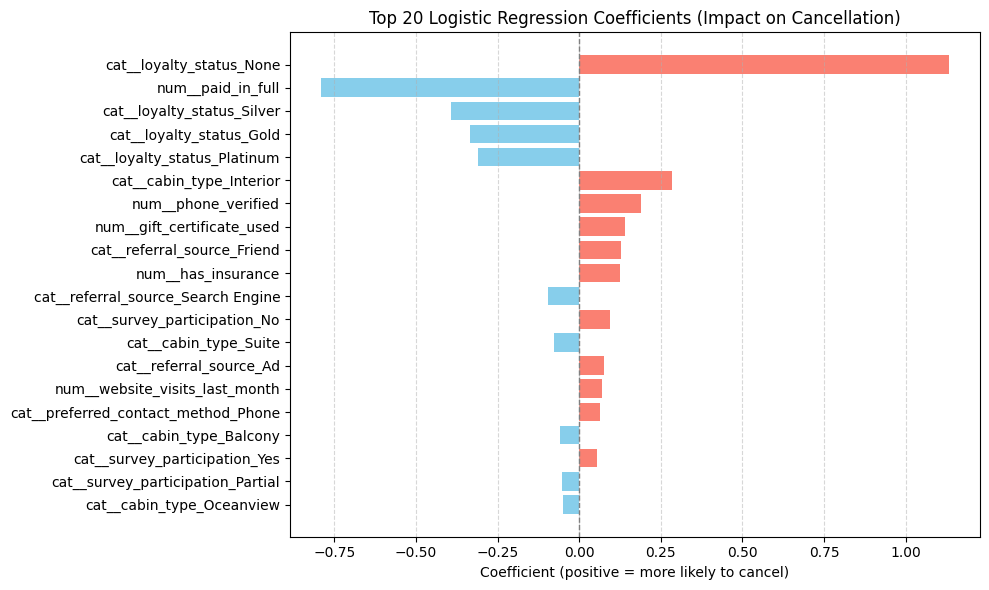

In [ ]:
lr_balanced_model = LogisticRegression(max_iter=1000, class_weight='balanced')

lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', lr_balanced_model)
])

lr_pipeline.fit(X_train, y_train)

feature_names = lr_pipeline.named_steps['preprocessor'].get_feature_names_out()

lr_coef = lr_pipeline.named_steps['classifier'].coef_[0]

top_n = 20
lr_top_idx = np.argsort(np.abs(lr_coef))[::-1][:top_n]

plt.figure(figsize=(10, 6))
colors = ['salmon' if coef > 0 else 'skyblue' for coef in lr_coef[lr_top_idx][::-1]]
plt.barh(range(top_n), lr_coef[lr_top_idx][::-1], color=colors)
plt.yticks(range(top_n), [feature_names[i] for i in lr_top_idx][::-1])
plt.axvline(0, color='gray', linestyle='--', linewidth=1)
plt.title("Top 20 Logistic Regression Coefficients (Impact on Cancellation)")
plt.xlabel("Coefficient (positive = more likely to cancel)")
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

By analyzing the top 20 most important characteristics provided by the logistic regression, we can see that loyalty status is the most influential variable in the logistic regression, with visitors with a loyalty status of “None” being the most likely to cancel a reservation, while having any kind of loyalty status makes them less likely to cancel a reservation.

In addition, whether or not they paid in full is also an important factor, as tourists are very unlikely to cancel a booking if they paid in full.Also, the type of cabin can have an impact. If a visitor has an “Interior” cabin, they are more likely to cancel their booking than visitors with other cabin types.

In summary, While there are other factors that come into play, in general, the more money a visitor spends, the less likely they are to cancel a trip; the less money a visitor spends, the more likely they are to cancel a trip.

From the previous analysis, it can be concluded that visitors with the following characteristics are most likely to cancel their bookings:

1. No loyalty status.

2. Partial payments or lower overall spending.

3. Booked in "Interior" cabins.

4. Budget-conscious or first-time customers.

So first, Lobster Land management can flag these groups in the reservation system and prepare ahead of time for the possibility of them canceling.

In addition, Lobster Land management should introduce incentives centered on consumer spending to reduce cancellations.

As for the loyalty programs, Offering discounts for joining the loyalty program at booking. Reward loyal customers with points for non-cancellation, redeemable for upgrades or discounts on future trips is also a good way.

As for the payment strategies, Lobster Land can Offer 5-10% discounts for paying in full upfront, and introduce a small non-refundable deposit for budget bookings to deter cancellations. Such customers often choose not to cancel their reservations due to the sunk costs caused by these non-refundable deposits.

As for the cabin type, Lobster Land can provide dynamic offers, give Interior cabin bookers with discounted upgrades to higher-tier cabins closer to the trip date. Also, Lobster Land can provides bundle packages, combining Interior cabins with non-refundable add-ons like dining packages to increase cancellation costs.

At the same time, we have found that many of the visitors with a tendency to cancel have verified their phone, got the cruise program primarily through friends, advertisements, or websites, and most have not engaged in customer research. So Lobster Land could upgrade the content of its ads and website by replacing text ads with short videos that show real cruise experiences. In addition, Lobster Land can provide an “invitation code” to visitors who have already purchased a ticket, so that if someone else uses the code, they can receive points, discounts or vouchers. Lobster Land should also conduct more post-cancellation surveys to collect information on the reasons for cancellations.

# 7. A/B Testing

Combined Performance Summary:

            photo  click_rate  avg_time_on_page
0  Caribbean Port    0.267442         23.156202
3  Tropical Beach    0.164557         25.955274
2      Night Glow    0.108209         22.605970
1      City Visit    0.086066         20.731967


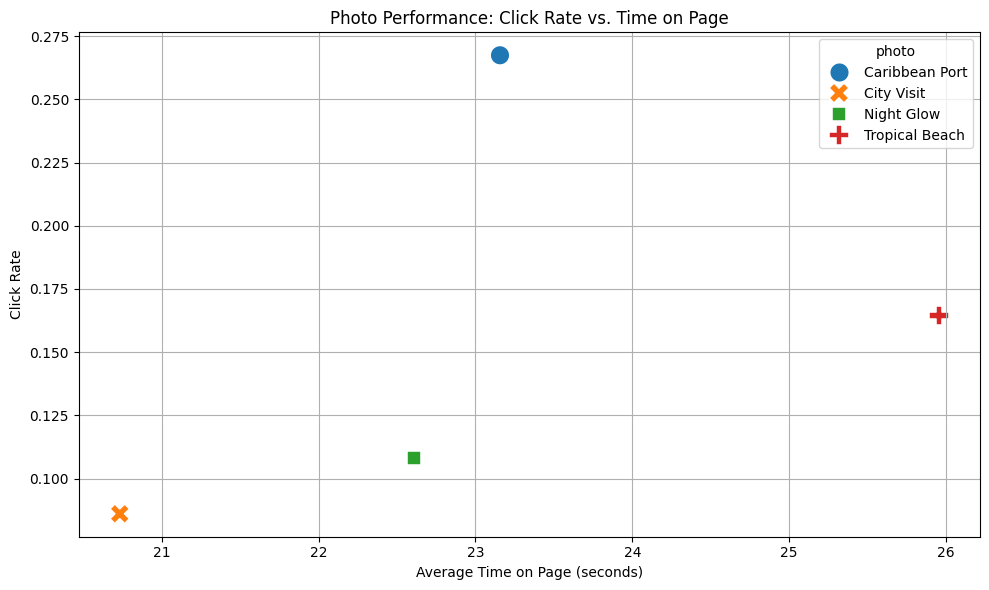

In [ ]:
df = pd.read_csv("data/cruise_pics.csv")  

summary_df = df.groupby("photo").agg({
    "clicked": "mean",
    "time_on_page": "mean"
}).reset_index()

summary_df.columns = ["photo", "click_rate", "avg_time_on_page"]

print("Combined Performance Summary:\n")
print(summary_df.sort_values(by=["click_rate", "avg_time_on_page"], ascending=False))

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=summary_df,
    x="avg_time_on_page",
    y="click_rate",
    hue="photo",
    s=200,
    style="photo"
)
plt.title("Photo Performance: Click Rate vs. Time on Page")
plt.xlabel("Average Time on Page (seconds)")
plt.ylabel("Click Rate")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
print("\nA/B Test Result:\n")

photo_A = "Caribbean Port"
photo_B = "Tropical Beach"  

group_A = df[df["photo"] == photo_A]
group_B = df[df["photo"] == photo_B]

clicks = np.array([group_A["clicked"].sum(), group_B["clicked"].sum()])
impressions = np.array([len(group_A), len(group_B)])

z_stat, p_value = proportions_ztest(clicks, impressions)

print(f"Clicks A ({photo_A}): {clicks[0]}/{impressions[0]}  |  Clicks B ({photo_B}): {clicks[1]}/{impressions[1]}")
print(f"Z-Statistic: {z_stat:.4f}")
print(f"P-Value: {p_value:.4f}")

alpha = 0.05
if p_value < alpha:
    print("Significant difference between A and B (reject H0)")
else:
    print("No significant difference between A and B (fail to reject H0)")


A/B Test Result:

Clicks A (Caribbean Port): 69/258  |  Clicks B (Tropical Beach): 39/237
Z-Statistic: 2.7687
P-Value: 0.0056
Significant difference between A and B (reject H0)


In order to help Lobster Land decide on the best promotional photo for their cruise campaign, we conducted an A/B/n test with random assignment by email to images and measured two key engagement metrics: click-through rate (CTR) and time on page. Beginning with a one-way ANOVA of time-on-page for the four images, we determined no statistically significant differences were present (p = 0.109). Although, a Chi-square test for binary clicked variable proved that there was substantial difference in the interaction of users with images (p < 0.001). We then graphed both metrics for all images and discovered that "Caribbean Port" had highest CTR (26.7%) and that "Tropical Beach" had longest mean view duration (26 seconds). Considering both action and attention-based performance, we recommend the best overall single image for the campaign is "Caribbean Port." Not only did it outperform all the others in driving clicks, but it remained competitive in terms of viewing time, and thus it was the best all-around image for engagement.

# 8. Conclusions

In this project, we have learned some useful knowledge about how Lobster Land can strategically expand into the cruise industry. By using the combination of segmentation, conjoint analysis, forecasting, classification, and A/B testing, we could find out trends not only indicating possible customer interests but also delineating main concerns of operations. For example, clustering analysis determined that there are various groups of ports through which various segments of the market can be addressed with tailor-made cruise itineraries, while conjoint analysis indicated that guest experience can significantly be enhanced through well-balancing of top-rated facilities within cost boundaries. Prediction of industry trends and cancelation risk forecasting also worked to reveal the need for Lobster Land to be planning cautiously but intensively.

In addition to the specific findings, one overarching lesson from our research is the importance of data-driven flexibility. Regardless of how innovative preliminary ideas may be, passenger preferences, cost of doing business, and market realities can shift quickly. Lobster Land will have to continue to invest in ongoing passenger analytics, iterative testing of in-flight experiences, and responsive marketing strategies to stay competitive. This project also reminded our team how crucial it is to connect quantitative analysis and strategic thinking: numbers are needed but not enough on their own—real value comes in when insights from data get connected to creative, customer-facing decisions.